### A - Initialisation et paramètres d’interrogation

In [1]:
station = "aula" 
dept = '09'
laps = 20

In [2]:
from IPython.display import display, Markdown
display(Markdown(f'### B - La température de ces derniers jours à **{station.title()}** ##'))

### B - La température de ces derniers jours à **Aula** ##

In [3]:
import duckdb
import pandas as pd

duckdb.execute("""
    PREPARE EVOL_STATION AS                      
        SELECT NOM_USUEL, ALTI, strptime(AAAAMMJJHH::varchar,'%Y%m%d%H') AS horaire, T
        FROM read_csv_auto('https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/HOR/H_' 
                            || ? || '_latest-2023-2024.csv.gz')
        WHERE lower(NOM_USUEL) like '%' || lower(?) || '%' 
        AND date_diff('days', horaire, current_date) <= ? AND T IS NOT NULL
        ORDER BY horaire DESC
""")

query = f"EXECUTE EVOL_STATION('{dept}','{station}',{laps})"

meteo_df = duckdb.execute(query).df()

meteo_df

,NOM_USUEL,ALTI,horaire,T
0,PORT D'AULA-NIVOSE,2140,2024-01-25 03:00:00,10.1
1,PORT D'AULA-NIVOSE,2140,2024-01-25 02:00:00,10.2
2,PORT D'AULA-NIVOSE,2140,2024-01-25 01:00:00,10.4
3,PORT D'AULA-NIVOSE,2140,2024-01-25 00:00:00,9.7
4,PORT D'AULA-NIVOSE,2140,2024-01-24 23:00:00,10.1
...,...,...,...,...
479,PORT D'AULA-NIVOSE,2140,2024-01-05 04:00:00,-2.9
480,PORT D'AULA-NIVOSE,2140,2024-01-05 03:00:00,-2.9
481,PORT D'AULA-NIVOSE,2140,2024-01-05 02:00:00,-2.8
482,PORT D'AULA-NIVOSE,2140,2024-01-05 01:00:00,-2.3


### C - Graphique d'évolution

Voici un graphique moche

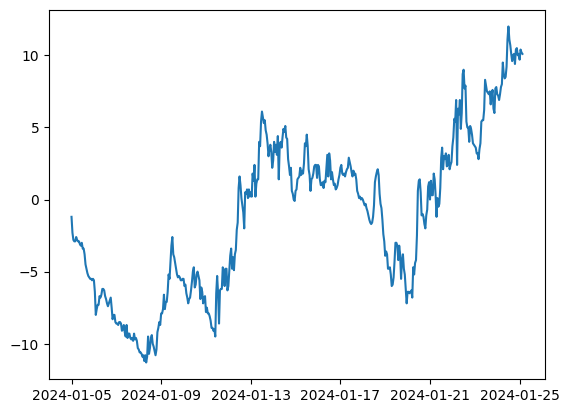

In [4]:
from matplotlib import pyplot as plt
# Créer une figure et des axes
fig, ax = plt.subplots()

# Tracer la courbe
ax.plot(meteo_df['horaire'], meteo_df['T'])

Et voici un **joli graphique** !

In [5]:
import altair as alt
from urllib import request
import json

# locale fr-FR pour les dates et autres.
with request.urlopen('https://raw.githubusercontent.com/d3/d3-format/master/locale/fr-FR.json') as f:
  fr_format = json.load(f)
with request.urlopen('https://raw.githubusercontent.com/d3/d3-time-format/master/locale/fr-FR.json') as f:
  fr_time_format = json.load(f)
alt.renderers.set_embed_options(formatLocale=fr_format, timeFormatLocale=fr_time_format)

RendererRegistry.enable('default')

In [6]:
chart = alt.Chart(meteo_df).mark_line(interpolate = "monotone").encode(
    x = alt.X('horaire:T', title = '', axis = alt.Axis(tickCount = 'day', format = '%e %b %Y')),
    y = alt.Y('T:Q',       title = '', axis = alt.Axis(labelExpr = 'datum.value + " °C"')),
    color = alt.value('hotpink'), 
    strokeWidth = alt.value(2),
).properties(
    width  = 1000,
    height = 400,
    title = { "text": f"Courbe de température à {dept} - {meteo_df.at[0,'NOM_USUEL']} (ces {laps} derniers jours)"}
)

line = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule().encode(
    y = 'y', strokeDash = alt.value([5, 5]),
)

line + chart 

alt.LayerChart(...)